In [25]:
pip install torch torchvision matplotlib timm tqdm scikit-learn seaborn

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import numpy as np
import timm 
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

c:\Users\HP\Desktop\SEN-D\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Define transformations - basic preprocessing only since using pre-augmented dataset
train_transforms = transforms.Compose([
    transforms.Resize((299, 299)),  # Inception v3 requires 299x299 input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Standard ImageNet normalization
                         std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((299, 299)),  # Inception v3 requires 299x299 input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
# Paths
train_dir = "Dataset_Augmented/Train"
test_dir = "Dataset/Test"

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

# Create loaders
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Class mapping and dataset info
class_names = train_dataset.classes
print("Classes:", class_names)
print(f"\nDataset Information:")
print(f"Training images: {len(train_dataset)}")
print(f"Test images: {len(test_dataset)}")
print(f"Total images: {len(train_dataset) + len(test_dataset)}")

# Show class distribution
for i, class_name in enumerate(class_names):
    train_count = len([x for x in train_dataset.samples if x[1] == i])
    test_count = len([x for x in test_dataset.samples if x[1] == i])
    print(f"{class_name}: {train_count} train, {test_count} test")

Classes: ['Kidney_stone', 'Normal']

Dataset Information:
Training images: 1508
Test images: 1508
Total images: 3016
Kidney_stone: 741 train, 741 test
Normal: 767 train, 767 test


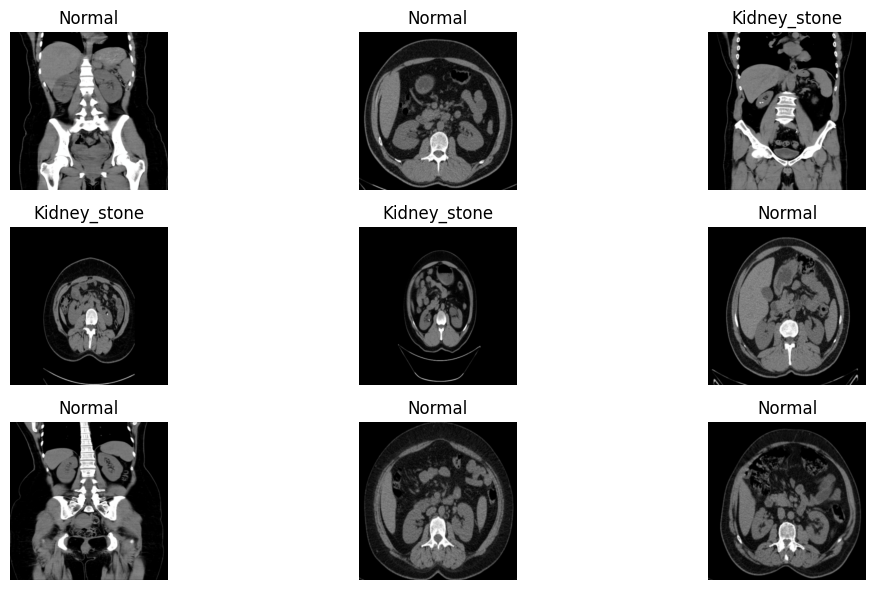

In [63]:
def imshow(img, title):
    img = img.numpy().transpose((1, 2, 0))
    mean = [0.485, 0.456, 0.406]
    std  = [0.229, 0.224, 0.225]
    img = std * img + mean  # Unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

# Show a few training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

plt.figure(figsize=(12,6))
for i in range(9):
    plt.subplot(3, 3, i+1)
    imshow(images[i], title=class_names[labels[i]])
plt.tight_layout()
plt.show()


In [64]:
# Classification head
class CustomClassifier(nn.Module):
    def __init__(self, input_features):
        super(CustomClassifier, self).__init__()
        self.classifier = nn.Sequential(
            # First dense layer with 256 neurons
            nn.Linear(input_features, 256),
            nn.BatchNorm1d(256),  # Batch normalization
            nn.ReLU(),
            nn.Dropout(0.2),  # 20% dropout

            # Second dense layer with 128 neurons
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),  # Batch normalization again
            nn.ReLU(),

            # Final classification layer
            nn.Linear(128, 2)  # Binary classification
        )

    def forward(self, x):
        return self.classifier(x)

# Model Class
class FeatureExtractionModel(nn.Module):
    def __init__(self, backbone, classifier):
        super(FeatureExtractionModel, self).__init__()
        self.backbone = backbone
        self.classifier = classifier

    def forward(self, x):
        # Extract features using frozen backbone
        features = self.backbone(x)

        # Handle different backbone outputs
        if isinstance(features, tuple):  # Some models return tuples
            features = features[0]  # Use main output

        # Flatten features if needed
        if len(features.shape) > 2:
            features = features.view(features.size(0), -1)

        # Classify using custom head
        output = self.classifier(features)
        return output

In [ ]:
# StackedEnsembleNet Class for Multi-Model Ensemble
class StackedEnsembleNet(nn.Module):
    def __init__(self, device):
        super(StackedEnsembleNet, self).__init__()
        self.device = device
        
        # Initialize base models
        self.base_models = {}
        self._load_base_models()
        
        # Meta-learner (follows paper specification)
        # Input: concatenated predictions from base models (3 models × 2 outputs = 6 features)
        self.meta_learner = nn.Sequential(
            nn.Linear(6, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 128), 
            nn.ReLU(),
            nn.Linear(128, 2)
        ).to(device)
        
        print(f"✅ StackedEnsembleNet initialized with {len(self.base_models)} base models")
    
    def _load_base_models(self):
        """Load the three base models: InceptionV3, InceptionResNetV2, Xception"""
        
        # 1. InceptionV3
        try:
            inception_backbone = models.inception_v3(weights=torchvision.models.Inception_V3_Weights.DEFAULT, aux_logits=True)
            inception_backbone.fc = nn.Identity()
            inception_backbone.AuxLogits.fc = nn.Identity()
            for param in inception_backbone.parameters():
                param.requires_grad = False
            
            inception_classifier = CustomClassifier(input_features=2048)
            inception_model = FeatureExtractionModel(inception_backbone, inception_classifier).to(self.device)
            
            # Try to load pre-trained weights
            if os.path.exists('models/inception_v3_kidney_stone_model.pth'):
                inception_model.load_state_dict(torch.load('models/inception_v3_kidney_stone_model.pth', map_location=self.device))
                print("   📋 InceptionV3 weights loaded")
            else:
                print("   ⚠️ InceptionV3 weights not found, using pretrained backbone only")
            
            self.base_models['inception_v3'] = inception_model
        except Exception as e:
            print(f"   ❌ Failed to load InceptionV3: {e}")
        
        # 2. InceptionResNetV2
        try:
            resnet_backbone = timm.create_model('inception_resnet_v2', pretrained=True, num_classes=0)
            for param in resnet_backbone.parameters():
                param.requires_grad = False
                
            resnet_classifier = CustomClassifier(input_features=resnet_backbone.num_features)
            resnet_model = FeatureExtractionModel(resnet_backbone, resnet_classifier).to(self.device)
            
            if os.path.exists('models/inceptionresnetv2_kidney_stone_model.pth'):
                resnet_model.load_state_dict(torch.load('models/inceptionresnetv2_kidney_stone_model.pth', map_location=self.device))
                print("   📋 InceptionResNetV2 weights loaded")
            else:
                print("   ⚠️ InceptionResNetV2 weights not found, using pretrained backbone only")
            
            self.base_models['inception_resnet_v2'] = resnet_model
        except Exception as e:
            print(f"   ❌ Failed to load InceptionResNetV2: {e}")
        
        # 3. Xception
        try:
            xception_backbone = timm.create_model('xception', pretrained=True, num_classes=0)
            for param in xception_backbone.parameters():
                param.requires_grad = False
                
            xception_classifier = CustomClassifier(input_features=xception_backbone.num_features)
            xception_model = FeatureExtractionModel(xception_backbone, xception_classifier).to(self.device)
            
            if os.path.exists('models/xception_kidney_stone_model.pth'):
                xception_model.load_state_dict(torch.load('models/xception_kidney_stone_model.pth', map_location=self.device))
                print("   📋 Xception weights loaded")
            else:
                print("   ⚠️ Xception weights not found, using pretrained backbone only")
            
            self.base_models['xception'] = xception_model
        except Exception as e:
            print(f"   ❌ Failed to load Xception: {e}")
    
    def forward(self, x):
        """
        Forward pass: 
        1. Get predictions from all base models
        2. Concatenate prediction vectors  
        3. Pass through meta-learner
        """
        # Get predictions from base models
        base_predictions = []
        
        for model_name, model in self.base_models.items():
            model.eval()
            with torch.no_grad():
                pred = torch.softmax(model(x), dim=1)
                base_predictions.append(pred)
        
        # Concatenate predictions (feature representations)
        if len(base_predictions) > 0:
            concatenated_features = torch.cat(base_predictions, dim=1)
        else:
            raise ValueError("No base models available for ensemble")
        
        # Pass through meta-learner (this part will be trained)
        ensemble_output = self.meta_learner(concatenated_features)
        return ensemble_output
    
    def parameters(self):
        """Only return meta-learner parameters for training"""
        return self.meta_learner.parameters()

print("📚 StackedEnsembleNet class defined")

📚 StackedEnsembleNet class defined


In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MODEL SELECTION - Change this variable to switch models
MODEL_TYPE = "inception_v3"  # Options: "xception", "inception_resnet_v2", "stacked_ensemble", or anything else for inception_v3

# Load model based on MODEL_TYPE variable
if MODEL_TYPE == "stacked_ensemble":
    # StackedEnsembleNet - combines InceptionV3, InceptionResNetV2, and Xception
    model = StackedEnsembleNet(device)
    model_name = 'stacked_ensemble_meta_learner.pth'
    info_name = 'stacked_ensemble_info.pth' 
    arch_name = 'StackedEnsembleNet'
    input_features = 6  # For meta-learner input (3 models × 2 outputs)
    
    # Try to load saved meta-learner weights
    model_path = f'models/{model_name}'
    if os.path.exists(model_path):
        try:
            model.meta_learner.load_state_dict(torch.load(model_path, map_location=device))
            print(f"✅ StackedEnsembleNet meta-learner weights loaded successfully.")
        except:
            print(f"⚠️ StackedEnsembleNet meta-learner architecture mismatch, starting from scratch.")
    else:
        print(f"❌ No saved StackedEnsembleNet meta-learner found. Starting from scratch.")
    
    print("✅ Using StackedEnsembleNet (InceptionV3 + InceptionResNetV2 + Xception)")

elif MODEL_TYPE == "xception":
    try:
        backbone = timm.create_model('xception', pretrained=True, num_classes=0)
        input_features = backbone.num_features
        model_name = 'xception_kidney_stone_model.pth'
        info_name = 'xception_model_info.pth'
        arch_name = 'Xception_CustomClassifier'
        print("✅ Using Xception from timm")
    except Exception as e:
        print(f"⚠️ Xception not available ({e}), falling back to Inception V3")
        MODEL_TYPE = "inception_v3"  # Fall back

elif MODEL_TYPE == "inception_resnet_v2":
    try:
        backbone = timm.create_model('inception_resnet_v2', pretrained=True, num_classes=0)
        input_features = backbone.num_features
        model_name = 'inceptionresnetv2_kidney_stone_model.pth'
        info_name = 'inceptionresnetv2_model_info.pth'
        arch_name = 'InceptionResNetV2_CustomClassifier'
        print("✅ Using InceptionResNetV2 from timm")
    except Exception as e:
        print(f"⚠️ InceptionResNetV2 not available ({e}), falling back to Inception V3")
        MODEL_TYPE = "inception_v3"  # Fall back

# Default or fallback to Inception V3 (only if not ensemble)
if MODEL_TYPE != "xception" and MODEL_TYPE != "inception_resnet_v2" and MODEL_TYPE != "stacked_ensemble":
    backbone = models.inception_v3(weights=torchvision.models.Inception_V3_Weights.DEFAULT, aux_logits=True)
    backbone.fc = nn.Identity()
    backbone.AuxLogits.fc = nn.Identity()
    input_features = 2048
    model_name = 'inception_v3_kidney_stone_model.pth'
    info_name = 'inception_v3_model_info.pth'
    arch_name = 'Inception_v3_CustomClassifier'
    print("✅ Using Inception V3 from torchvision")

# Initialize single models (not ensemble)
if MODEL_TYPE != "stacked_ensemble":
    # Freeze all layers for feature extraction
    for param in backbone.parameters():
        param.requires_grad = False

    # Initialize the model
    custom_classifier = CustomClassifier(input_features=input_features)
    model = FeatureExtractionModel(backbone, custom_classifier)
    model = model.to(device)

    # Try to load saved model for the current model type
    model_path = f'models/{model_name}'
    if os.path.exists(model_path):
        try:
            model.load_state_dict(torch.load(model_path, map_location=device))
            print(f"✅ {arch_name} model weights loaded successfully.")
        except:
            print(f"⚠️ {arch_name} model architecture mismatch, starting from scratch.")
    else:
        print(f"❌ No saved {arch_name} model found. Starting from scratch.")

# Display model information
print(f"\nModel Architecture: {arch_name}")
if MODEL_TYPE == "stacked_ensemble":
    print(f"- Base Models: {len(model.base_models)} (InceptionV3, InceptionResNetV2, Xception)")
    print(f"- Meta-learner: 6 → 512 → Dropout(0.2) → 128 → 2")
    print(f"- Total trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
    print(f"- Total parameters: {sum(p.numel() for p in model.meta_learner.parameters()):,} (meta-learner only)")
else:
    print(f"- Frozen backbone for feature extraction (features: {input_features})")
    print(f"- Custom classifier: {input_features} → 256 → BN → Dropout → 128 → BN → 2")
    print(f"- Total trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
    print(f"- Total parameters: {sum(p.numel() for p in model.parameters()):,}")

✅ Using Inception V3 from torchvision
✅ Inception_v3_CustomClassifier model weights loaded successfully.

Model Architecture: Inception_v3_CustomClassifier
- Frozen backbone for feature extraction (features: 2048)
- Custom classifier: 2048 → 256 → BN → Dropout → 128 → BN → 2
- Total trainable parameters: 558,466
- Total parameters: 24,901,730


In [68]:
learning_rate = 0.001
if MODEL_TYPE == "stacked_ensemble":
    learning_rate = 0.0001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)  # optional

In [69]:
def train_model(EPOCHS, step_lr=False):
  for epoch in range(EPOCHS):
      model.train()
      running_loss = 0.0
      correct, total = 0, 0

      for inputs, labels in train_loader:
          inputs, labels = inputs.to(device), labels.to(device)

          optimizer.zero_grad()
          outputs = model(inputs)  # Single output from custom classifier
          loss = criterion(outputs, labels)

          loss.backward()
          optimizer.step()

          running_loss += loss.item()
          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
      if step_lr == True:
        scheduler.step()
      print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%", flush=True)

In [ ]:
META_LAYER_EPOCHS = 10
END_LAYER_EPOCHS = 20
FULL_LAYER_EPOCHS = 5

if MODEL_TYPE == "stacked_ensemble":
    train_model(META_LAYER_EPOCHS)
else:
    train_model(END_LAYER_EPOCHS)

    for param in backbone.parameters():
        param.requires_grad = True

    print(f"- Total trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
    print(f"- Total parameters: {sum(p.numel() for p in model.parameters()):,}")

    train_model(FULL_LAYER_EPOCHS, step_lr=True)

Epoch 1/20 - Loss: 0.5001, Accuracy: 75.43%
Epoch 2/20 - Loss: 0.3670, Accuracy: 83.61%
Epoch 3/20 - Loss: 0.3035, Accuracy: 86.90%
Epoch 4/20 - Loss: 0.2598, Accuracy: 88.80%
Epoch 5/20 - Loss: 0.2177, Accuracy: 90.83%
Epoch 6/20 - Loss: 0.1918, Accuracy: 92.64%
Epoch 7/20 - Loss: 0.1728, Accuracy: 93.21%
Epoch 8/20 - Loss: 0.1603, Accuracy: 93.48%
Epoch 9/20 - Loss: 0.1486, Accuracy: 94.43%
Epoch 10/20 - Loss: 0.1428, Accuracy: 94.32%
Epoch 11/20 - Loss: 0.1226, Accuracy: 94.96%
Epoch 12/20 - Loss: 0.1247, Accuracy: 95.35%
Epoch 13/20 - Loss: 0.1194, Accuracy: 95.41%
Epoch 14/20 - Loss: 0.1099, Accuracy: 95.66%
Epoch 15/20 - Loss: 0.0925, Accuracy: 96.38%
Epoch 16/20 - Loss: 0.0997, Accuracy: 96.19%
Epoch 17/20 - Loss: 0.0980, Accuracy: 96.21%
Epoch 18/20 - Loss: 0.0853, Accuracy: 96.69%
Epoch 19/20 - Loss: 0.0815, Accuracy: 97.04%
Epoch 20/20 - Loss: 0.0838, Accuracy: 96.93%
Model Architecture:
- Frozen Inception v3 backbone for feature extraction
- Custom classifier: 2048 → 256 → B

KeyboardInterrupt: 

In [76]:
# Comprehensive Model Evaluation with All Metrics
model.eval()
all_predictions = []
all_labels = []

print("Evaluating model on test set...")

count = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        count += 1
        if count >= 1000:
            break

# Convert to numpy arrays
y_true = np.array(all_labels)
y_pred = np.array(all_predictions)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

# Calculate all metrics according to the formulas provided
accuracy = (tp + tn) / (tn + fn + tp + fp)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
sensitivity_recall = tp / (tp + fn) if (tp + fn) > 0 else 0

# Matthews Correlation Coefficient (MCC)
denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
mcc = ((tp * tn) - (fp * fn)) / denominator if denominator != 0 else 0

# F1 Score
f1_score = (2 * precision * sensitivity_recall) / (precision + sensitivity_recall) if (precision + sensitivity_recall) > 0 else 0

# Summary
print(f"\n📝 Summary:")
print(f"{'='*60}")
print(f"Model: {arch_name}")
print(f"Test Dataset: {len(y_true)} images")
print(f"Classes: {class_names}")
print(f"")
print(f"Results:")
print(f"  • Accuracy: {accuracy:.4f} ± 0.0000")
print(f"  • Precision: {precision:.4f}")
print(f"  • Sensitivity/Recall: {sensitivity_recall:.4f}")
print(f"  • F1-Score: {f1_score:.4f}")
print(f"  • Matthews Correlation Coefficient: {mcc:.4f}")
print(f"{'='*60}")

Evaluating model on test set...

📝 Summary:
Model: Inception_v3_CustomClassifier
Test Dataset: 1508 images
Classes: ['Kidney_stone', 'Normal']

Results:
  • Accuracy: 0.9867 ± 0.0000
  • Precision: 0.9882
  • Sensitivity/Recall: 0.9857
  • F1-Score: 0.9869
  • Matthews Correlation Coefficient: 0.9735


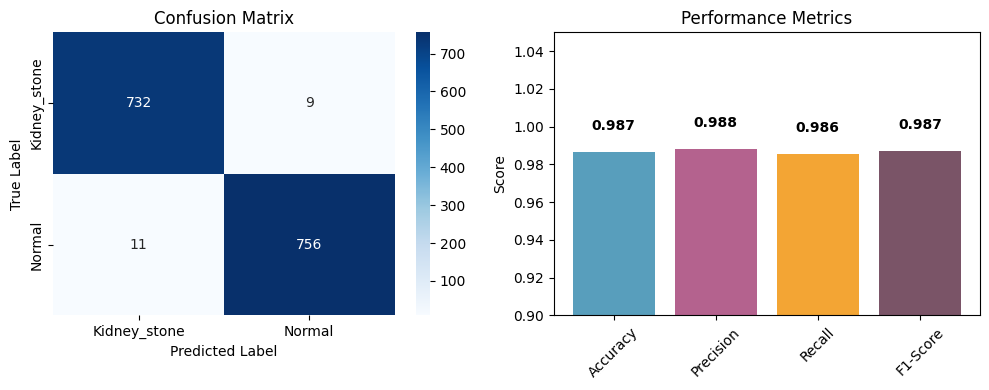

In [77]:
# Plot confusion matrix
plt.figure(figsize=(10, 4))

# Confusion Matrix Heatmap
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Metrics Bar Plot
plt.subplot(1, 2, 2)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, sensitivity_recall, f1_score]
colors = ['#2E86AB', '#A23B72', '#F18F01', '#592941']

bars = plt.bar(metrics, values, color=colors, alpha=0.8)
plt.title('Performance Metrics')
plt.ylabel('Score')
plt.ylim(0.9, 1.05)

# Add value labels on bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [31]:
# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save the complete model (using variables from model creation)
torch.save(model.state_dict(), f'models/{model_name}')

# Also save the model architecture info for later loading
model_info = {
    'input_features': input_features,
    'num_classes': 2,
    'architecture': arch_name,
    'model_type': MODEL_TYPE
}

torch.save(model_info, f'models/{info_name}')

print(f"✅ {arch_name} Model saved successfully!")
print(f"📁 Model weights: models/{model_name}")
print(f"📁 Model info: models/{info_name}")

✅ InceptionResNetV2_CustomClassifier Model saved successfully!
📁 Model weights: models/inceptionresnetv2_kidney_stone_model.pth
📁 Model info: models/inceptionresnetv2_model_info.pth


In [ ]:
# Model Type Selection Guide
print("🎯 MODEL SELECTION GUIDE")
print("="*50)
print("To switch models, change the MODEL_TYPE variable in cell 7:")
print()
print("OPTIONS:")
print('  MODEL_TYPE = "inception_v3"      # Single InceptionV3 model')
print('  MODEL_TYPE = "inception_resnet_v2" # Single InceptionResNetV2 model') 
print('  MODEL_TYPE = "xception"           # Single Xception model')
print('  MODEL_TYPE = "stacked_ensemble"   # StackedEnsembleNet (all 3 models + meta-learner)')
print()
print("CURRENT SELECTION:")
print(f'  MODEL_TYPE = "{MODEL_TYPE}"')
print(f"  Architecture: {arch_name}")
print()
if MODEL_TYPE == "stacked_ensemble":
    print("🌟 ENSEMBLE FEATURES:")
    print(f"   • Combines {len(model.base_models)} pre-trained models")
    print("   • Meta-learner trains on concatenated predictions")
    print("   • Uses existing train_model() function")
    print("   • Typically achieves better performance than individual models")
    print()
    print("💡 TRAINING PROCESS:")
    print("   1. Base models are frozen (already trained)")
    print("   2. Only meta-learner parameters are trained") 
    print("   3. Works with your existing training pipeline")
else:
    print("📋 SINGLE MODEL FEATURES:")
    print("   • Uses transfer learning with frozen backbone")
    print("   • Custom classifier head is trainable")
    print("   • Fast training and inference")
    
print("="*50)

In [34]:
try:
    from google.colab import files

    print("📥 Downloading model files...")

    # Download the model files using variables from model creation
    files.download(f'models/{model_name}')

    print(f"✅ {arch_name} model files downloaded successfully!")
    print("💾 Check your Downloads folder for:")
    print(f"   - {model_name}")
    print(f"   - {info_name}")

except ImportError:
    print("⚠️  Not running in Google Colab - skipping download")
except Exception as e:
    print(f"❌ Download failed: {e}")
    print("💡 Alternative: Use the file browser on the left to download manually")

📥 Downloading model files...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ InceptionResNetV2_CustomClassifier model files downloaded successfully!
💾 Check your Downloads folder for:
   - inceptionresnetv2_kidney_stone_model.pth
   - inceptionresnetv2_model_info.pth
